In [1]:
import numpy as np
#
# The function in this file follow closely after the MATLAB scripts
# written by Alessandro Foi and Markku Makitalo - Tampere University
# of Technology - 2011-2012
#
#    http://www.cs.tut.fi/~foi/invansc/
#
# that accompanies their paper:
#
#    Reference: M. Makitalo and A. Foi, "Optimal inversion of the
#    generalized Anscombe transformation for Poisson-Gaussian noise",
#    IEEE Trans. Image Process., doi:10.1109/TIP.2012.2202675


#-------- Variance stabilizing transforms -----------

def anscombe(x):
    '''
    Compute the anscombe variance stabilizing transform.
      the input   x   is noisy Poisson-distributed data
      the output  fx  has variance approximately equal to 1.
    Reference: Anscombe, F. J. (1948), "The transformation of Poisson,
    binomial and negative-binomial data", Biometrika 35 (3-4): 246-254
    '''
    return 2.0*np.sqrt(x + 3.0/8.0)

def inverse_anscombe(z):
    '''
    Compute the inverse transform using an approximation of the exact
    unbiased inverse.
    Reference: Makitalo, M., & Foi, A. (2011). A closed-form
    approximation of the exact unbiased inverse of the Anscombe
    variance-stabilizing transformation. Image Processing.
    '''
    #return (z/2.0)**2 - 3.0/8.0
    return (1.0/4.0 * np.power(z, 2) +
            1.0/4.0 * np.sqrt(3.0/2.0) * np.power(z, -1.0) -
            11.0/8.0 * np.power(z, -2.0) + 
            5.0/8.0 * np.sqrt(3.0/2.0) * np.power(z, -3.0) - 1.0 / 8.0)

def generalized_anscombe(x, mu, sigma, gain=1.0):
    '''
    Compute the generalized anscombe variance stabilizing transform,
    which assumes that the data provided to it is a mixture of poisson
    and gaussian noise.
    The input signal  z  is assumed to follow the Poisson-Gaussian noise model
        x = gain * p + n
    where gain is the camera gain and mu and sigma are the read noise
    mean and standard deviation.
    We assume that x contains only positive values.  Values that are
    less than or equal to 0 are ignored by the transform.
    Note, this transform will show some bias for counts less than
    about 20.
    '''
    y = gain*x + (gain**2)*3.0/8.0 + sigma**2 - gain*mu

    # Clamp to zero before taking the square root.
    return (2.0/gain)*np.sqrt(np.maximum(y, 0.0))

def inverse_generalized_anscombe(x, mu, sigma, gain=1.0):
    '''
    Applies the closed-form approximation of the exact unbiased
    inverse of Generalized Anscombe variance-stabilizing
    transformation.
    The input signal x is transform back into a Poisson random variable
    based on the assumption that the original signal from which it was
    derived follows the Poisson-Gaussian noise model:
        x = gain * p + n
    where gain is the camera gain and mu and sigma are the read noise
    mean and standard deviation.
    Roference: M. Makitalo and A. Foi, "Optimal inversion of the
    generalized Anscombe transformation for Poisson-Gaussian noise",
    IEEE Trans. Image Process., doi:10.1109/TIP.2012.2202675
    '''
    test = np.maximum(x, 1.0)
    exact_inverse = ( np.power(test/2.0, 2.0) +
                      1.0/4.0 * np.sqrt(3.0/2.0)*np.power(test, -1.0) -
                      11.0/8.0 * np.power(test, -2.0) +
                      5.0/8.0 * np.sqrt(3.0/2.0) * np.power(test, -3.0) -
                      1.0/8.0 - np.power(sigma, 2) )
    exact_inverse = np.maximum(0.0, exact_inverse)
    exact_inverse *= gain
    exact_inverse += mu
    exact_inverse[np.where(exact_inverse != exact_inverse)] = 0.0
    return exact_inverse

#def inverse_generalized_anscombe(y,mu,sigma,gain=1.0):
#    return (1.0/gain)*(gain*y/2.0)**2 - gain*3.0/8.0 - (sigma**2)/gain + mu

In [2]:
from bm3d import bm3d, BM3DProfile
import numpy as np
import scipy.misc
from matplotlib import pyplot as plt
from tifffile import imread, imsave

In [3]:
noisy = imread('../../../experiments/fairSim/2020-07-27/Zeiss/p2/Zeiss_Mito_600nm_crop_Poisson-n2.tif').astype(np.float32)

clean = imread('../../../experiments/fairSim/2020-07-27/Zeiss/Zeiss_Mito_600nm_crop.tif').astype(np.float32)
print(noisy.shape)
print(clean.shape)


(5, 25, 512, 512)
(5, 25, 512, 512)


In [4]:
offset=100
from tqdm import tqdm
mses=[]
denoisedImgs=[]
bestMSE = None
bestImg = None
bestSig= None

for s in range(40):
    sig = (s+1)*2.5
    #denoised=noisy.copy()
    j=0
    #for i in range(5):
    i=0
#        print(i,j)

    img=noisy[i,j,...]
    cl= clean[i,j,...]

        
    ans=anscombe(img-offset)
    denoised = inverse_anscombe (bm3d (ans,sig)) + offset
    
        
    mse = np.mean((cl-denoised)**2)
    mses.append(mse)
    denoisedImgs.append(denoised.copy())
    
    if bestMSE is None or (mse<bestMSE):
        bestImg = denoised.copy()
        bestMSE = mse
        bestSig = sig
    print (sig, bestSig, mse)

        

2.5 2.5 3640.107628771426
5.0 5.0 1918.7090548743342
7.5 5.0 2071.0190320622964
10.0 5.0 2272.911291712
12.5 5.0 2519.105872807375
15.0 5.0 2794.63309539943
17.5 5.0 3087.96372390043
20.0 5.0 3391.915828105221
22.5 5.0 3695.7537060901914
25.0 5.0 4003.9234667859027
27.5 5.0 4302.132832864458
30.0 5.0 4597.88502363755
32.5 5.0 4893.585977469049
35.0 5.0 5187.074852496286
37.5 5.0 5473.403639286125
40.0 5.0 5765.087782204581
42.5 5.0 6040.041176054906
45.0 5.0 6318.817073745551
47.5 5.0 6589.291390095611
50.0 5.0 6844.400446593176
52.5 5.0 7095.90588817523
55.0 5.0 7340.147058045866
57.5 5.0 7579.294674518961
60.0 5.0 7809.922088304482
62.5 5.0 8030.412153089298
65.0 5.0 8245.093277307882
67.5 5.0 8460.378627347834
70.0 5.0 8664.18777141872
72.5 5.0 8866.653285005166
75.0 5.0 9065.760008056637
77.5 5.0 9258.613511096746
80.0 5.0 9453.172078273446
82.5 5.0 9643.555535491047
85.0 5.0 9837.002720167726
87.5 5.0 10027.36967857286
90.0 5.0 10217.68203192193
92.5 5.0 10409.557980948022
95.0 5.

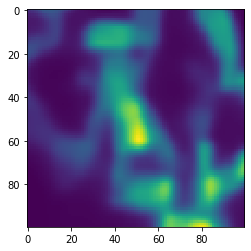

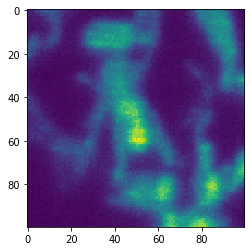

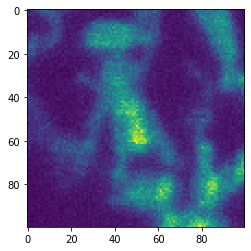

In [5]:
plt.imshow(denoisedImgs[11][100:200,100:200])
plt.show()
plt.imshow(cl[100:200,100:200])
plt.show()
plt.imshow(img[100:200,100:200])


In [6]:
offset=100
from tqdm import tqdm
denoised=noisy.copy()

for j in tqdm(range(25)):
    for i in range(5):
        img=noisy[i,j,...]
        cl= clean[i,j,...]

        sig = bestSig

        ans=anscombe(img-offset)
        denoisedImg = inverse_anscombe (bm3d (ans,sig)) + offset
        denoised[i,j,...] = denoisedImg
    


imsave('../../../experiments/fairSim/2020-07-27/Zeiss/p2/n2_VST-BM3D.tif', denoised)
        

100%|██████████| 25/25 [1:02:23<00:00, 149.74s/it]
